# 07b_physical_variables_to_edges (Guadalajara only)

This notebook __transfers variables to the edges__ (which already contain slope, from notebook 07a)
* ndvi_mean (vegetation)
* entropy (land use)
* banqueta_pct (sidewalks)
* average_density (population)
* average_intersdens (intersections density)

## Import libraries

In [1]:
first_folder_path = '../../../'

In [2]:
import warnings
warnings.filterwarnings('ignore')
import geopandas as gpd
from geopandas.tools import overlay
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import seaborn as sns
import random
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, mean_squared_error
#import tensorflow as tf
#from keras.models import Sequential
#from keras.layers import Dense
#from tensorflow.keras.utils import to_categorical
import time

import os
import sys
module_path = os.path.abspath(os.path.join(first_folder_path))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup
else:
    import aup

## Notebook config

In [46]:
# ----- ----- ----- Projection to be used when needed ----- ----- -----
projected_crs = "EPSG:32613"
# ----- ----- ----- Save output locally?
local_save = False

## __Load data__ (Project nodes and project edges)

In [4]:
#Previous
#G, nodes, edges = aup.graph_from_hippo(hex_gdf, schema='osmnx', edges_folder='edges_elevation_23_line', nodes_folder='nodes_osmnx_23_point')

In [5]:
#Previous
#nodes = nodes.reset_index()
#nodes.head(2)

In [6]:
#Previous
#edges = edges.reset_index()
#edges.head(2)

In [7]:
#Previous
#edges_var = edges.copy()
#edges_var = edges_var.reset_index()
#edges_var = edges_var.to_crs("EPSG:32613")
#edges_var = edges_var[['u','v','key','osmid','grade_abs','geometry']] # Ya contiene a las prendientes.

In [8]:
# Read file
nodes = gpd.read_file(first_folder_path + "data/processed/volvo/slope_to_edges_gdl/nodes_elev_mde.gpkg")
# Filter for data of interest
nodes = nodes[['osmid','x','y','street_count','elevation','geometry']]
# Review CRS
if nodes.crs != projected_crs:
    nodes = nodes.to_crs(projected_crs)
    print(f"Changed crs to {projected_crs}.")

# Show
print(nodes.shape)
nodes.head(2)

Changed crs to EPSG:32613.
(124621, 6)


,osmid,x,y,street_count,elevation,geometry
0,67637870229114485,-103.306309,20.711533,3.0,1548.0,POINT (676378.709 2291144.858)
1,67640019229114922,-103.306102,20.711570,3.0,1548.0,POINT (676400.196 2291149.223)


In [9]:
# Read file
edges = gpd.read_file(first_folder_path + "data/processed/volvo/slope_to_edges_gdl/edges_elev_mde.gpkg")
# Filter for data of interest
edges = edges[['u','v','key','grade_abs','geometry']]
# Review CRS
if edges.crs != projected_crs:
    edges = edges.to_crs(projected_crs)
    print(f"Changed crs to {projected_crs}.")

# Show
print(edges.shape)
edges.head(2)

Changed crs to EPSG:32613.
(197439, 5)


,u,v,key,grade_abs,geometry
0,67637870229114485,67640019229114922,0,0.0,"MULTILINESTRING ((676378.709 2291144.858, 6763..."
1,67640019229114922,67640526229117504,0,0.0,"MULTILINESTRING ((676400.196 2291149.223, 6764..."


## Edges buffer (Used to transfer various data to edges)

In [10]:
# Crear un buffer alrededor de los edges
edges_buffer = edges.copy()
edges_buffer['geometry'] = edges_buffer.buffer(30)

# Convertir a coordenadas proyectadas para cálculos espaciales
if edges_buffer.crs != projected_crs:
    edges_buffer = edges_buffer.to_crs(projected_crs)
    print(f"Changed crs to {projected_crs}.")

# Show
print(edges_buffer.crs)
print(edges_buffer.shape)
edges_buffer.head(2)

EPSG:32613
(197439, 5)


,u,v,key,grade_abs,geometry
0,67637870229114485,67640019229114922,0,0.0,"POLYGON ((676383.891 2291174.416, 676384.524 2..."
1,67640019229114922,67640526229117504,0,0.0,"POLYGON ((676376.307 2291167.315, 676375.851 2..."


## Add __NDVI__ to analysis

In [11]:
ndvi_schema = "raster_analysis"
ndvi_table = "ndvi_analysis_hex"

query = f"SELECT * FROM {ndvi_schema}.{ndvi_table} WHERE city IN ('Guadalajara') AND res = 11";
ndvi_gdl = aup.gdf_from_query(query, geometry_col='geometry')
# Review CRS
if ndvi_gdl.crs != projected_crs:
    ndvi_gdl = ndvi_gdl.to_crs(projected_crs)
    print(f"Changed crs to {projected_crs}.")

# Show
print(ndvi_gdl.shape)
ndvi_gdl.head(2)

Changed crs to EPSG:32613.
(480618, 17)


,hex_id,geometry,res,ndvi_mean,ndvi_std,ndvi_median,ndvi_max,ndvi_min,ndvi_diff,ndvi_tend,ndvi_2018,ndvi_2019,ndvi_2020,ndvi_2021,ndvi_2022,ndvi_2023,city
0,8b49ab48628cfff,"POLYGON ((662523.277 2298555.399, 662541.17 22...",11,0.079373,0.018171,0.078366,0.105550,0.060136,0.045414,-0.000492,0.087883,0.086345,0.090842,0.081467,0.065691,0.064008,Guadalajara
1,8b49ab591290fff,"POLYGON ((663840.705 2283799.874, 663858.596 2...",11,0.037707,0.024608,0.034858,0.065107,0.018002,0.047105,-0.000743,0.046563,0.053209,0.049051,0.054013,0.009180,0.014228,Guadalajara


In [12]:
# Overlay con intersection (Unión espacial que genera geometrías de intersección entre ambos polígonos, conservando todas las columnas del primer gdf y las columnas únicas del segundo)
edges_ndvi = gpd.overlay(edges, ndvi_gdl, how='intersection')

# Show
print(edges_ndvi.crs)
print(edges_ndvi.shape)
edges_ndvi.head(2)

EPSG:32613
(548304, 21)


,u,v,key,grade_abs,hex_id,res,ndvi_mean,ndvi_std,ndvi_median,ndvi_max,...,ndvi_diff,ndvi_tend,ndvi_2018,ndvi_2019,ndvi_2020,ndvi_2021,ndvi_2022,ndvi_2023,city,geometry
0,67637870229114485,67640019229114922,0,0.0,8b498c943189fff,11,0.118923,0.042181,0.125918,0.151654,...,0.064316,-0.001704,0.172745,0.142202,0.131524,0.127633,0.072387,0.067046,Guadalajara,"LINESTRING (676378.709 2291144.858, 676386.243..."
1,67640019229114922,67640526229117504,0,0.0,8b498c943016fff,11,0.253372,0.060187,0.273914,0.304821,...,0.096148,-0.002156,0.307192,0.287902,0.280230,0.284966,0.187874,0.172069,Guadalajara,"LINESTRING (676407.226 2291165.144, 676407.32 ..."


In [13]:
# Calcular la media del NDVI por cada calle (usando 'u', 'v', 'key' como identificadores)
ndvi_per_edge = edges_ndvi.groupby(['u', 'v', 'key'])['ndvi_mean'].mean().reset_index()

# Unir los datos de NDVI agregados con el dataset original de edges
edges_var_1 = edges.merge(ndvi_per_edge, on=['u', 'v', 'key'], how='left')

# Rellenar valores nulos con 0
edges_var_1['ndvi_mean'] = edges_var_1['ndvi_mean'].fillna(0)

# Show
print(edges_var_1.shape)
print(edges_var_1.isna().sum())
edges_var_1.head(2)

(197439, 6)
u              0
v              0
key            0
grade_abs    336
geometry       0
ndvi_mean      0
dtype: int64


,u,v,key,grade_abs,geometry,ndvi_mean
0,67637870229114485,67640019229114922,0,0.0,"MULTILINESTRING ((676378.709 2291144.858, 6763...",0.118923
1,67640019229114922,67640526229117504,0,0.0,"MULTILINESTRING ((676400.196 2291149.223, 6764...",0.188798


<Axes: >

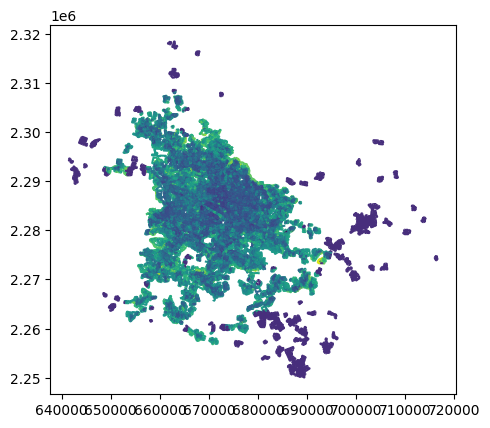

In [14]:
edges_var_1.plot("ndvi_mean")

## Add __Land Use__ to analysis

In [15]:
# Load data
land_use = gpd.read_file(first_folder_path + "data/processed/volvo/uso_suelo_gdl/predios_uso_suelo.geojson")
# Ensure projected CRS
if land_use.crs != projected_crs:
    land_use = land_use.to_crs(projected_crs)
    print(f"Changed crs to {projected_crs}.")

# Show
print(land_use.crs)
print(land_use.shape)
print(land_use['clasificacion_uso_suelo'].unique())
land_use.head(2)

EPSG:32613
(677371, 2)
['Residencial' 'Complementarios' 'ComercialServicios' 'Mixto' 'Industrial'
 'Equipamiento']


,clasificacion_uso_suelo,geometry
0,Residencial,"POLYGON ((668816.105 2295371.324, 668811.832 2..."
1,Residencial,"POLYGON ((668729.69 2295298.382, 668723.108 22..."


In [16]:
# Overlay con intersection (Unión espacial que genera geometrías de intersección entre ambos polígonos, conservando todas las columnas del primer gdf y las columnas únicas del segundo)
start_time = time.time()
land_use_intersection = gpd.overlay(edges_buffer, land_use, how='intersection')
finish_time = time.time()

# Show
print(f'Edges buffer intersecting land use. Time: {round(finish_time-start_time,0)}s.')
print(land_use_intersection.crs)
print(land_use_intersection.shape)
land_use_intersection.head(2)

Edges buffer intersecting land use. Time: 60.0s.
EPSG:32613
(2493274, 6)


,u,v,key,grade_abs,clasificacion_uso_suelo,geometry
0,67637870229114485,67640019229114922,0,0.0,Residencial,"POLYGON ((676392.15 2291122.12, 676390.68 2291..."
1,67637870229114485,67640019229114922,0,0.0,Complementarios,"POLYGON ((676387.021 2291113.74, 676384.404 22..."


In [17]:
def calcular_entropia(unique_id, percentage_series):

    # If unique_id has no data, assign NaN to avoid having an impact on statistics
    if unique_id not in percentage_series.index:
        return np.nan
    # If unique_id has just one value (no variety), entropy = 0
    elif len(percentage_series.loc[unique_id]) == 1:
        return 0
    # Else, calculate and return entropy
    probs = percentage_series.loc[unique_id].values
    return -np.sum(probs * np.log2(probs))

start_time = time.time()

# Var 2 store
edges_var_2 = edges_var_1.copy()
# Calcular el área de intersección
land_use_intersection['area_inte'] = land_use_intersection.geometry.area

# Calcular la proporción de cada uso de suelo
area_usos_edges = land_use_intersection.groupby(['u', 'v', 'key'])['area_inte'].sum()
land_use_presence_edges = land_use_intersection.groupby(['u', 'v', 'key', 'clasificacion_uso_suelo'])['area_inte'].sum()
percentage_land_use_edges = land_use_presence_edges / area_usos_edges

print("Número de intersecciones:", len(land_use_intersection))
print("Número de calles únicas con intersecciones:", land_use_intersection[['u', 'v', 'key']].nunique())

# Calcular el número de categorías por calle
#n_land_use = land_use_intersection.groupby(['u', 'v', 'key'])['clasificacion_uso_suelo'].unique().apply(len)

# Aplicar la fórmula de entropía de Shannon
edges_var_2['entropy'] = edges_var_2.set_index(['u', 'v', 'key']).index.map(lambda idx: calcular_entropia(idx, percentage_land_use_edges))

finish_time = time.time()

# Show
print(f'Land use entropy calculation. Time: {round(finish_time-start_time,0)}s.')
print(edges_var_2.crs)
print(edges_var_2.shape)
edges_var_2.head(2)

Número de intersecciones: 2493274
Número de calles únicas con intersecciones: u      56455
v      56202
key        3
dtype: int64
Land use entropy calculation. Time: 40.0s.
EPSG:32613
(197439, 7)


,u,v,key,grade_abs,geometry,ndvi_mean,entropy
0,67637870229114485,67640019229114922,0,0.0,"MULTILINESTRING ((676378.709 2291144.858, 6763...",0.118923,1.144632
1,67640019229114922,67640526229117504,0,0.0,"MULTILINESTRING ((676400.196 2291149.223, 6764...",0.188798,0.317370


<Axes: >

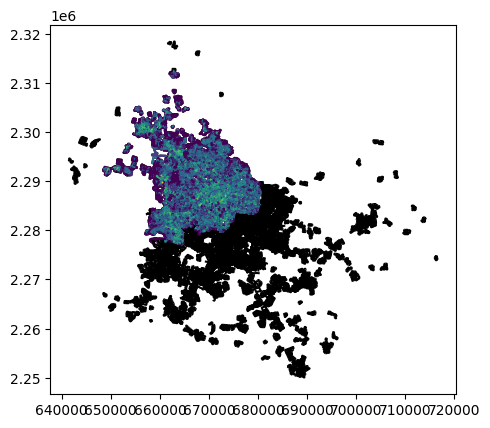

In [20]:
fig,ax = plt.subplots()

edges_var_2.plot('entropy',ax=ax,zorder=1)
edges_var_2.plot(color='black',ax=ax,zorder=0)

## Add __Sidewalks__ to analysis

In [21]:
# Create poly_wkt from city's hexgrid
hexs_type = "urban"
city = "Guadalajara"
query_urban = f"SELECT * FROM hexgrid.hexgrid_8_city_2020 WHERE \"city\" LIKE \'{city}\' AND \"type\" LIKE \'{hexs_type}\'"
hex_gdf = aup.gdf_from_query(query_urban, geometry_col='geometry')
gdf_tmp = hex_gdf.copy()
gdf_tmp = gdf_tmp.to_crs(projected_crs)
gdf_tmp = gdf_tmp.buffer(1).reset_index().rename(columns={0:'geometry'})
gdf_tmp = gdf_tmp.set_geometry("geometry")
gdf_tmp = gdf_tmp.to_crs("EPSG:4326")
poly_wkt = gdf_tmp.dissolve().geometry.to_wkt()[0]

In [23]:
# Load sidewalks
query = f"SELECT * FROM urbano.fm_inegi_20_line WHERE ST_Intersects(geometry, \'SRID=4326;{poly_wkt}\')"
sidewalks = aup.gdf_from_query(query, geometry_col='geometry')
# Ensure projected CRS
if sidewalks.crs != projected_crs:
    sidewalks = sidewalks.to_crs(projected_crs)
    print(f"Changed crs to {projected_crs}.")

# Show
print(sidewalks.crs)
print(sidewalks.shape)
sidewalks.head(4)

Changed crs to EPSG:32613.
EPSG:32613
(261012, 68)


,CVEGEO2,CVE_ENT,CVE_MUN,CVE_LOC,CVE_AGEB,CVE_MZA,CVEVIAL_x,CVESEG,CVEFT_x,NOMVIAL_x,...,ESTACIONBICI,ARBOLES,ALUMPUB,TELPUB,PUESTOSEMI,PUESTOAMBU,BANQUETA,GUARNICION,TAMLOC,VIANOESP
0,1412000013185020,14,120,0001,3185,020,07967,00001,4,Ninguno,...,3,3,3,3,3,3,3,1,11,0
1,1412000013185020,14,120,0001,3185,020,07967,00001,6,Ninguno,...,3,3,1,3,3,3,3,1,11,0
2,1412000011850003,14,120,0001,1850,003,04876,00008,4,Trafalgar,...,3,1,1,3,3,3,1,1,11,0
3,1412000011850006,14,120,0001,1850,006,07991,00001,3,Pasamontes,...,3,1,3,3,3,3,1,1,11,0


In [24]:
# Explore data
sidewalks.columns

Index(['CVEGEO2', 'CVE_ENT', 'CVE_MUN', 'CVE_LOC', 'CVE_AGEB', 'CVE_MZA',
       'CVEVIAL_x', 'CVESEG', 'CVEFT_x', 'NOMVIAL_x', 'TIPOVIAL', 'CVEVIAL1',
       'CVESEG1', 'CVEREF1', 'TIPOVR1', 'NOMREF1', 'CVEVIAL2', 'CVESEG2',
       'CVEREF2', 'TIPOVR2', 'NOMREF2', 'CVEVIAL3', 'CVESEG3', 'CVEREF3',
       'TIPOVR3', 'NOMREF3', 'geometry', 'CVEGEO', 'CVEGEOFTE', 'ID_FTE',
       'ID_MZA', 'ENT', 'MUN', 'LOC', 'AGEB', 'MZA', 'CVEFT_y', 'CVEVIAL_y',
       'NOMVIAL_y', 'NOMVIAL_C', 'TIPOVIAL_C', 'ESVIALIDAD', 'CLASEVIA',
       'CLASERASGO', 'OTRORASGO_C', 'RECUCALLE', 'RESTRICPEAT', 'RESTRICAUTO',
       'PASOPEAT', 'DRENAJEP', 'TRANSCOL', 'CICLOVIA', 'CICLOCARRIL',
       'LETRERO', 'RAMPAS', 'SEMAFOROPEAT', 'SEMAFOROAUDI', 'PARADATRANS',
       'ESTACIONBICI', 'ARBOLES', 'ALUMPUB', 'TELPUB', 'PUESTOSEMI',
       'PUESTOAMBU', 'BANQUETA', 'GUARNICION', 'TAMLOC', 'VIANOESP'],
      dtype='object')

In [25]:
# Explore sidewalks data
print(sidewalks['BANQUETA'].unique())

[3 1 8 9]


In [26]:
# Filter for BANQUETA with data
# Data in INEGI's "Descriptores de la base de datos frentes de manzana INV2020" file:
# 1 = Dispone
# 3 = No dispone
# 7 = Conjunto habitacional
# 8 = No Aplica
# 9 = No especificado

sidewalks_withdata = sidewalks[sidewalks['BANQUETA'].isin([1,3,7,8])].copy()
sidewalks_withdata.geom_type.unique()

array(['LineString'], dtype=object)

In [28]:
# Intersect sidewalks with edge's 30 meter buffer
sidewalks_intersections = sidewalks_withdata.overlay(edges_buffer, how='intersection')
# Add length data to each intersected sidewalk
sidewalks_intersections['length'] = sidewalks_intersections.length

# Show
print(sidewalks_intersections.shape)
sidewalks_intersections.head(2)

(1748992, 73)


,CVEGEO2,CVE_ENT,CVE_MUN,CVE_LOC,CVE_AGEB,CVE_MZA,CVEVIAL_x,CVESEG,CVEFT_x,NOMVIAL_x,...,BANQUETA,GUARNICION,TAMLOC,VIANOESP,u,v,key,grade_abs,geometry,length
0,1412000013185020,14,120,0001,3185,020,07967,00001,4,Ninguno,...,3,1,11,0,66664598229476136,66663438229471416,0,0.020492,"LINESTRING (666668.831 2294780.756, 666663.342...",19.871654
1,1412000013185020,14,120,0001,3185,020,07967,00001,4,Ninguno,...,3,1,11,0,66665770229475735,66670111229474341,0,0.000000,"LINESTRING (666670.024 2294784.909, 666663.342...",24.192546


In [29]:
# Group intersected sidewalks by unique edge ID (u,v,key) and BANQUETA code
banqueta_edges = sidewalks_intersections[['u','v','key','BANQUETA','length']].groupby(['u','v','key','BANQUETA']).sum()
banqueta_edges = banqueta_edges.reset_index()

# Show
print(banqueta_edges.shape)
banqueta_edges.head(2)

(284342, 5)


,u,v,key,BANQUETA,length
0,65037254229258000,65046238229270983,0,8,22.636270
1,65046238229270983,65068351229268555,0,3,443.843216


In [30]:
# Store third variable data
edges_var_3 = edges_var_2.copy()

# Sidewalk available (1)
edges_var_3 = edges_var_3.merge(banqueta_edges.loc[banqueta_edges.BANQUETA==1,['u','v','key','length']],
                                on=['u','v','key'],
                                how='left'
                               )
edges_var_3 = edges_var_3.rename(columns={'length':'sidewalk_available'})

# Sidewalk not available (3, 7 or 8)
edges_var_3 = edges_var_3.merge(banqueta_edges.loc[banqueta_edges.BANQUETA.isin([3,7,8]),['u','v','key','length']],
                                on=['u','v','key'],
                                how='left'
                               )
edges_var_3 = edges_var_3.rename(columns={'length':'no_sidewalk_available'})

# Show
print(edges_var_3.crs)
print(edges_var_3.shape)
edges_var_3.head(2)

EPSG:32613
(225093, 9)


,u,v,key,grade_abs,geometry,ndvi_mean,entropy,sidewalk_available,no_sidewalk_available
0,67637870229114485,67640019229114922,0,0.0,"MULTILINESTRING ((676378.709 2291144.858, 6763...",0.118923,1.144632,179.791185,69.176583
1,67640019229114922,67640526229117504,0,0.0,"MULTILINESTRING ((676400.196 2291149.223, 6764...",0.188798,0.317370,181.014513,68.547498


In [31]:
# Since no sidewalks are composed by various groups, group lengths
nosidewalk_group = edges_var_3.groupby(['u', 'v', 'key']).agg({'no_sidewalk_available':np.sum})
nosidewalk_group.reset_index(inplace=True)

# Merge with previous data
edges_var_3_fixed = edges_var_3.copy()
edges_var_3_fixed.drop(columns=['no_sidewalk_available'],inplace=True)
edges_var_3_fixed = pd.merge(edges_var_3_fixed, nosidewalk_group, on=['u','v','key'])
edges_var_3_fixed.drop_duplicates(inplace=True)

# Calculate pct of available sidewalk
edges_var_3_fixed['banqueta_pct'] = edges_var_3_fixed['sidewalk_available'] / (edges_var_3_fixed['sidewalk_available'] + edges_var_3_fixed['no_sidewalk_available'])

# Show
print(edges_var_3_fixed.crs)
print(edges_var_3_fixed.shape)
edges_var_3_fixed.head(2)

EPSG:32613
(197439, 10)


,u,v,key,grade_abs,geometry,ndvi_mean,entropy,sidewalk_available,no_sidewalk_available,banqueta_pct
0,67637870229114485,67640019229114922,0,0.0,"MULTILINESTRING ((676378.709 2291144.858, 6763...",0.118923,1.144632,179.791185,69.176583,0.722146
1,67640019229114922,67640526229117504,0,0.0,"MULTILINESTRING ((676400.196 2291149.223, 6764...",0.188798,0.317370,181.014513,68.547498,0.725329


<Axes: >

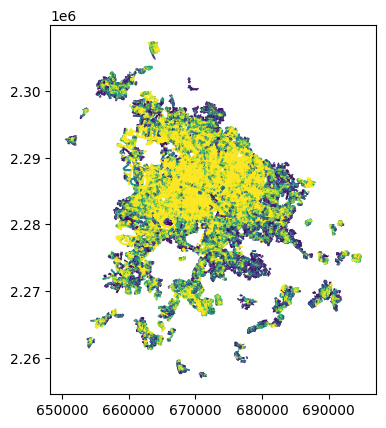

In [32]:
edges_var_3_fixed.plot('banqueta_pct')

In [33]:
previous = """
if intersections.empty:
    print("No hay intersecciones. Saltando...")
    edges_buffer['sidewalk'] = 0  
else:
    # Asegurar que ambos GeoDataFrames tienen el mismo CRS
    if edges_buffer.crs != projected_crs:
        edges_buffer = edges_buffer.to_crs(projected_crs)
        print(f"Changed edges_buffer crs to {projected_crs}.")
    
    if intersections.crs != projected_crs:
        intersections = intersections.to_crs(projected_crs)
        print(f"Changed intersections crs to {projected_crs}.")

    # Inicializar la columna 'sidewalk' con 0
    edges_buffer['sidewalk'] = 0  

    total_count = len(edges_buffer)
    progress_logs = [1,2,3,4,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100] # for log statistics
    i = 1
    start_time = time.time()
    
    # Iterar sobre cada buffer en edges_buffer
    for idx, edge in edges_buffer.iterrows():
        
        # Measures current progress, prints if passed a checkpoint of progress_logs list.
        current_progress = (i / total_count)*100
        for checkpoint in progress_logs:
            if current_progress >= checkpoint:

                checkpoint_time = time.time()
                time_since = checkpoint_time - start_time
                print(f'Calculating length of available sidewalks. {checkpoint}% done. Time so far: {round(time_since,0)}s.')
                progress_logs.remove(checkpoint)
                break
        
        # Filtrar las banquetas contenidas en el buffer
        sidewalks_in_buffer = intersections[intersections['geometry'].within(edge['geometry'])]
        
        # Calcular la longitud total de banquetas dentro del buffer
        total_length = sidewalks_in_buffer['geometry'].length.sum()
        
        # Calcular la longitud de banquetas con BANQUETA = 1
        length_with_sidewalks = sidewalks_in_buffer[sidewalks_in_buffer['BANQUETA'] == 1]['geometry'].length.sum()
        
        # Evitar división por cero y calcular la proporción de banquetas
        if total_length > 0:
            edges_buffer.at[idx, 'sidewalk'] = length_with_sidewalks / total_length
        else:
            edges_buffer.at[idx, 'sidewalk'] = 0  # Si no hay banquetas en el buffer, asignar 0

        i+=1

# Convertir a CRS original y guardar resultados
edges_buffer = edges_buffer.to_crs('epsg:4326')
#edges_buffer.to_file('sidewalks_edges.geojs0019229114922on', driver='GeoJSON')"""

## Add __Population__ to analysis

In [34]:
prev="""
nodes_id = edges_var.v.unique().tolist()
u = edges_var.u.unique().tolist()
nodes_id.extend(u)
myset = set(nodes_id)
nodes_id = list(myset)
schema = 'censo'
nodes_folder = 'pobcenso_inegi_20_mzaageb_node'
nodes_query = f"SELECT * FROM {schema}.{nodes_folder} WHERE osmid IN {str(tuple(nodes_id))}"
nodes_pop = aup.gdf_from_query(nodes_query, geometry_col="geometry", index_col="osmid")
"""

In [35]:
prev="""
voronoi = gpd.read_file('/home/jovyan/accesibilidad-urbana/data/external/Guadalajara_script22_voronoipolys.gpkg')
voronoi = voronoi.to_crs("EPSG:32613")
voronoi['area_ha'] = voronoi.area/10000
"""

In [36]:
prev="""
# Realiza el merge para unir los datos de población y área desde `voronoi_gdf` a `nodes_gdf` basado en "osmid"
nodes_pop = nodes_pop.merge(
    voronoi[['osmid', 'area_ha']],  # Selecciona solo las columnas necesarias de voronoi_gdf
    on='osmid',
    how='left'
    )

# Verifica las primeras filas para asegurarte de que el merge se realizó correctamente
nodes_pop.head(3
"""

In [37]:
prev="""
nodes_pop['dens'] = nodes_pop['pobtot'] / nodes_pop['area_ha']
nodes_pop.head(3)
"""

In [38]:
# Load nodes with pop data
nodes_pop = gpd.read_file(first_folder_path + "data/processed/volvo/project_network_initial_guadalajara/guadalajara_voronois_pop_gdf_b.gpkg")

# Review CRS
if nodes_pop.crs != projected_crs:
    nodes_pop = nodes_pop.to_crs(projected_crs)
    print(f"Changed crs to {projected_crs}.")

# Show
print(nodes_pop.shape)
nodes_pop.head(2)

(115837, 5)


,osmid,pobtot,area_has,dens_pob_ha,geometry
0,65394725226151578,5,2.479128,2.016838,"MULTIPOLYGON (((653974.51 2261588.625, 654089...."
1,67016094225777232,0,1.627780,0.000000,"MULTIPOLYGON (((670224.748 2257775.742, 670214..."


In [39]:
# Store fourth variable data
edges_var_4 = edges_var_3_fixed.copy()

# Merge data for osmids in 'u'
edges_var_4 = edges_var_4.merge(nodes_pop[['osmid','pobtot','dens_pob_ha']],
                            left_on='u', right_on='osmid',
                            how='left')
edges_var_4 = edges_var_4.rename(columns={'pobtot':'pobtot_u',
                                      'dens_pob_ha':'dens_u'}
                            )
edges_var_4.drop(columns='osmid',inplace=True)

# Merge data for osmids in 'v'
edges_var_4 = edges_var_4.merge(nodes_pop[['osmid','pobtot','dens_pob_ha']],
                           left_on='v', right_on='osmid',
                           how='left')
edges_var_4 = edges_var_4.rename(columns={'pobtot':'pobtot_v',
                                      'dens_pob_ha':'dens_v'}
                            )
edges_var_4.drop(columns='osmid',inplace=True)

# Show
edges_var_4.head(2)

,u,v,key,grade_abs,geometry,ndvi_mean,entropy,sidewalk_available,no_sidewalk_available,banqueta_pct,pobtot_u,dens_u,pobtot_v,dens_v
0,67637870229114485,67640019229114922,0,0.0,"MULTILINESTRING ((676378.709 2291144.858, 6763...",0.118923,1.144632,179.791185,69.176583,0.722146,80.0,153.566318,27.0,111.104363
1,67640019229114922,67640526229117504,0,0.0,"MULTILINESTRING ((676400.196 2291149.223, 6764...",0.188798,0.317370,181.014513,68.547498,0.725329,27.0,111.104363,5.0,31.101049


In [40]:
# Calcular valores de cada edge
edges_var_4["average_population"] = (edges_var_4['pobtot_u'] + edges_var_4['pobtot_v']) / 2
edges_var_4["total_pobtot"] = edges_var_4['pobtot_u'] + edges_var_4['pobtot_v']
edges_var_4['average_density'] = edges_var_4[['dens_u','dens_v']].mean(axis=1)

# Show
edges_var_4.head(2)

,u,v,key,grade_abs,geometry,ndvi_mean,entropy,sidewalk_available,no_sidewalk_available,banqueta_pct,pobtot_u,dens_u,pobtot_v,dens_v,average_population,total_pobtot,average_density
0,67637870229114485,67640019229114922,0,0.0,"MULTILINESTRING ((676378.709 2291144.858, 6763...",0.118923,1.144632,179.791185,69.176583,0.722146,80.0,153.566318,27.0,111.104363,53.5,107.0,132.335341
1,67640019229114922,67640526229117504,0,0.0,"MULTILINESTRING ((676400.196 2291149.223, 6764...",0.188798,0.317370,181.014513,68.547498,0.725329,27.0,111.104363,5.0,31.101049,16.0,32.0,71.102706


## Add __Intersection density__ to analysis

Used GIS to generate:
1. __Create node density heatmap__ using Kernel Density Estimation
> * Point layer: guadalajara_tessellations_nodes_consolidation_5m.shp (In EPSG:32613)
> * Radius: 400m
> * Pixel size X and Pixel size Y: 5
> * Kernel shape: Quadratic
2. __Transfer raster data to nodes__ using Sample raster values
> * Input layer: guadalajara_nodes_proj_net_rebuilt [EPSG:32613]
> * Raster layer: guadalajara_intersections_400m_5pixels [EPSG:32613]
3. __Transfer nodes data to edges__ (edge = (u_node+v_node)/2)

In [41]:
# Load data
intersections_density = gpd.read_file(first_folder_path + "data/processed/volvo/intersection_density_gdl/guadalajara_nodes_proj_net_rebuilt_nodesdensity.gpkg")
# Ensure projected CRS
if intersections_density.crs != projected_crs:
    intersections_density = intersections_density.to_crs(projected_crs)
    print(f"Changed crs to {projected_crs}.")

# Show
print(intersections_density.crs)
print(intersections_density.shape)
intersections_density.head(2)

EPSG:32613
(124621, 9)


,osmid,ntw_origin,streets_count,x,y,street_count,cluster,SAMPLE_1,geometry
0,67637870229114485,ntw_01,3,676378.709485,2.291145e+06,3,NaN,19.498764,POINT (676378.709 2291144.858)
1,67640019229114922,ntw_01,3,676400.196372,2.291149e+06,3,NaN,19.071526,POINT (676400.196 2291149.223)


In [42]:
# Store fourth variable data
edges_var_5 = edges_var_4.copy()

# Merge data for osmids in 'u'
edges_var_5 = edges_var_5.merge(intersections_density[['osmid','SAMPLE_1']],
                                left_on='u', right_on='osmid',
                                how='left')
edges_var_5 = edges_var_5.rename(columns={'SAMPLE_1':'interdens_u'}
                                )
edges_var_5.drop(columns='osmid',inplace=True)

# Merge data for osmids in 'v'
edges_var_5 = edges_var_5.merge(intersections_density[['osmid','SAMPLE_1']],
                           left_on='v', right_on='osmid',
                           how='left')
edges_var_5 = edges_var_5.rename(columns={'SAMPLE_1':'interdens_v'}
                                )
edges_var_5.drop(columns='osmid',inplace=True)

# Show
edges_var_5.head(2)

,u,v,key,grade_abs,geometry,ndvi_mean,entropy,sidewalk_available,no_sidewalk_available,banqueta_pct,pobtot_u,dens_u,pobtot_v,dens_v,average_population,total_pobtot,average_density,interdens_u,interdens_v
0,67637870229114485,67640019229114922,0,0.0,"MULTILINESTRING ((676378.709 2291144.858, 6763...",0.118923,1.144632,179.791185,69.176583,0.722146,80.0,153.566318,27.0,111.104363,53.5,107.0,132.335341,19.498764,19.071526
1,67640019229114922,67640526229117504,0,0.0,"MULTILINESTRING ((676400.196 2291149.223, 6764...",0.188798,0.317370,181.014513,68.547498,0.725329,27.0,111.104363,5.0,31.101049,16.0,32.0,71.102706,19.071526,19.041632


In [43]:
# Calculate the average density between the two nodes connected by the edge
edges_var_5["average_intersdens"] = (edges_var_5['interdens_u'] + edges_var_5['interdens_v']) / 2

# Show
edges_var_5.head(2)

,u,v,key,grade_abs,geometry,ndvi_mean,entropy,sidewalk_available,no_sidewalk_available,banqueta_pct,pobtot_u,dens_u,pobtot_v,dens_v,average_population,total_pobtot,average_density,interdens_u,interdens_v,average_intersdens
0,67637870229114485,67640019229114922,0,0.0,"MULTILINESTRING ((676378.709 2291144.858, 6763...",0.118923,1.144632,179.791185,69.176583,0.722146,80.0,153.566318,27.0,111.104363,53.5,107.0,132.335341,19.498764,19.071526,19.285145
1,67640019229114922,67640526229117504,0,0.0,"MULTILINESTRING ((676400.196 2291149.223, 6764...",0.188798,0.317370,181.014513,68.547498,0.725329,27.0,111.104363,5.0,31.101049,16.0,32.0,71.102706,19.071526,19.041632,19.056579


## __Final output__

In [44]:
# Retrieve original lines geometries (edges_var_4's geometries contain the buffers)
edges_var_df_cols = ['u', 'v', 'key',
                     'grade_abs',
                     'ndvi_mean','entropy',
                     'sidewalk_available','no_sidewalk_available','banqueta_pct',
                     'pobtot_u','pobtot_v','total_pobtot','average_population',
                     'dens_u','dens_v','average_density',
                     'interdens_u','interdens_v','average_intersdens']

edges_var_final = pd.merge(edges_var_5[edges_var_df_cols],edges[['u','v','key','geometry']],on=['u','v','key'])
edges_var_final = gpd.GeoDataFrame(edges_var_final,geometry='geometry',crs=projected_crs)

# Show
print(type(edges_var_final))
print(edges_var_final.geom_type.unique())
print(edges_var_final.crs)
print(edges_var_final.shape)
edges_var_final.head(2)

<class 'geopandas.geodataframe.GeoDataFrame'>
['MultiLineString']
EPSG:32613
(197439, 20)


,u,v,key,grade_abs,ndvi_mean,entropy,sidewalk_available,no_sidewalk_available,banqueta_pct,pobtot_u,pobtot_v,total_pobtot,average_population,dens_u,dens_v,average_density,interdens_u,interdens_v,average_intersdens,geometry
0,67637870229114485,67640019229114922,0,0.0,0.118923,1.144632,179.791185,69.176583,0.722146,80.0,27.0,107.0,53.5,153.566318,111.104363,132.335341,19.498764,19.071526,19.285145,"MULTILINESTRING ((676378.709 2291144.858, 6763..."
1,67640019229114922,67640526229117504,0,0.0,0.188798,0.317370,181.014513,68.547498,0.725329,27.0,5.0,32.0,16.0,111.104363,31.101049,71.102706,19.071526,19.041632,19.056579,"MULTILINESTRING ((676400.196 2291149.223, 6764..."


In [45]:
if local_save:
    edges_var_final.to_file(first_folder_path + "data/processed/volvo/edges_var_gdl/edges_var_gdl.gpkg")